#60% FYP - Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Loading the Features

In [ ]:
# Import necessary libraries and modules
import pickle
import numpy as np
import pandas as pd
import spacy
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.2.2


In [ ]:
# Loading features from the pickle files that was saved in 30%
with open("/content/drive/MyDrive/features/train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

with open("/content/drive/MyDrive/features/test_features.pkl", "rb") as f:
    test_features = pickle.load(f)

# Convert features into DataFrames
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [ ]:
train_df.sample(n=1)

,pos_tags,named_entities,sentiment,bert_embedding,Label,Label_Value
4221,"[(South, PROPN), (Carolina, PROPN), (has, VERB...","(South, Carolina, has, the, fastest, -, growin...","(0.0, 0.0)","[[-0.79124254, -0.8277107, -0.026014766, 0.300...",True,1


#Represeting Features In Numerical Format

##POS_Tags

In [ ]:
# Define the POS tags to keep
tags_to_keep = {'ADJ', 'ADV', 'CCONJ', 'INTJ', 'NOUN', 'PROPN'}

# Extract POS tags as a list of strings, keeping only the tags in tags_to_keep
train_pos_tags = train_df['pos_tags'].apply(lambda x: [tag[1] for tag in x if tag[1] in tags_to_keep])
test_pos_tags = test_df['pos_tags'].apply(lambda x: [tag[1] for tag in x if tag[1] in tags_to_keep])

# Define a function to create a count matrix for POS tags
def create_count_matrix(tag_list, unique_tags):
    count_matrix = np.zeros((len(tag_list), len(unique_tags)), dtype=int)
    for i, tags in enumerate(tag_list):
        for tag in tags:
            count_matrix[i, unique_tags.index(tag)] += 1
    return count_matrix

# Get a list of all unique POS tags after filtering
all_unique_pos_tags = list(tags_to_keep)

# Create count matrices for POS tags after filtering
pos_tags_count_train = create_count_matrix(train_pos_tags, all_unique_pos_tags)
pos_tags_count_test = create_count_matrix(test_pos_tags, all_unique_pos_tags)


In [ ]:
pos_tags_count_train[2]

array([2, 7, 0, 0, 0, 0])

##Flattening Bert Sentence Embedding

In [ ]:
# Extract BERT embeddings
train_bert_embeddings = train_df['bert_embedding'].tolist()
test_bert_embeddings = test_df['bert_embedding'].tolist()

# Function to flatten BERT embeddings
def flatten_bert_embeddings(embeddings):
    return np.array([np.concatenate(embedding).ravel() for embedding in embeddings])

# Flatten BERT embeddings
train_bert_embeddings = flatten_bert_embeddings(train_bert_embeddings)
test_bert_embeddings = flatten_bert_embeddings(test_bert_embeddings)


In [ ]:
# Extract sentiment scores
sentiment_train = np.array(train_df['sentiment'].to_list())
sentiment_test = np.array(test_df['sentiment'].to_list())


##Counting Named Entity

In [ ]:
# Define a list of unique named entity types you want to track
unique_entity_types = ['EVENT', 'ORDINAL', 'DATE', 'TIME', 'QUANTITY', 'FAC', 'PERSON', 'ORG', 'WORK_OF_ART', 'GPE', 'LAW', 'NORP', 'PERCENT', 'LOC', 'CARDINAL', 'LANGUAGE', 'MONEY', 'PRODUCT']

# Define a function to create a count matrix for named entity types
def create_entity_type_count_matrix(entity_list, unique_types):
    count_matrix = np.zeros((len(entity_list), len(unique_types)), dtype=int)
    for i, doc in enumerate(entity_list):
        for entity in doc.ents:
            if entity.label_ in unique_types:
                count_matrix[i, unique_types.index(entity.label_)] += 1
    return count_matrix

# Create count matrices for named entity types
entity_type_count_train = create_entity_type_count_matrix(train_df['named_entities'], unique_entity_types)
entity_type_count_test = create_entity_type_count_matrix(test_df['named_entities'], unique_entity_types)


In [ ]:
entity_type_count_train[1]

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

##Concatenating Features


In [ ]:
# Create a feature matrix by combining BERT embeddings, POS tag counts, named entity type counts, and sentiment scores
def create_feature_matrix(bert_embeddings, pos_tags_count, entity_type_count, sentiment_scores):
    feature_matrix = np.hstack((bert_embeddings, pos_tags_count, entity_type_count, sentiment_scores))
    return feature_matrix

# Create feature matrices for the train and test sets
train_feature_matrix = create_feature_matrix(train_bert_embeddings, pos_tags_count_train, entity_type_count_train, sentiment_train)
test_feature_matrix = create_feature_matrix(test_bert_embeddings, pos_tags_count_test, entity_type_count_test, sentiment_test)


In [ ]:
train_feature_matrix.shape

(10239, 794)

#Model Training

In [ ]:
# Respective Labels for training and testign dataset
train_labels = train_df['Label_Value'].astype(int)
test_labels = test_df['Label_Value'].astype(int)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Define a StratifiedKFold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and train a Random Forest classifier with hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(train_feature_matrix, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_



# Assuming best_rf_classifier is your trained Random Forest model
model_filename = '/content/drive/MyDrive/model/random_forest_model.pkl'
joblib.dump(best_rf_classifier, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/model/random_forest_model.pkl


#Evaluation

In [ ]:
# Make predictions on the training set
train_predictions = best_rf_classifier.predict(train_feature_matrix)

# Calculate the training accuracy
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.8793495458540874




*   Precision measures how many of the “positive” predictions made by the model were correct.  **Precision = TP / (TP + FP)**
*   Recall measures how many of the positive class samples present in the dataset were correctly identified by the model. Recall = TP / (TP + FN)
*   The accuracy metric computes how many times a model made a correct prediction across the entire dataset.
* F1-Score = 2 * (Precision * Recall) / (Precision + Recall)





In [ ]:
# Make predictions on the validation set
test_predictions = best_rf_classifier.predict(test_feature_matrix)
test_accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Test Accuracy: 0.8173495458540874
Precision: 82.349545854087691
Recall: 0.7966339410939691
F1-Score: 0.803941093969178


##Confusion Matrix
1. True Positives (TP): Number of samples correctly predicted as “positive.”
2. False Positives (FP): Number of samples wrongly predicted as “positive.”
3. True Negatives (TN): Number of samples correctly predicted as “negative.”
4. False Negatives (FN): Number of samples wrongly predicted as “negative.”

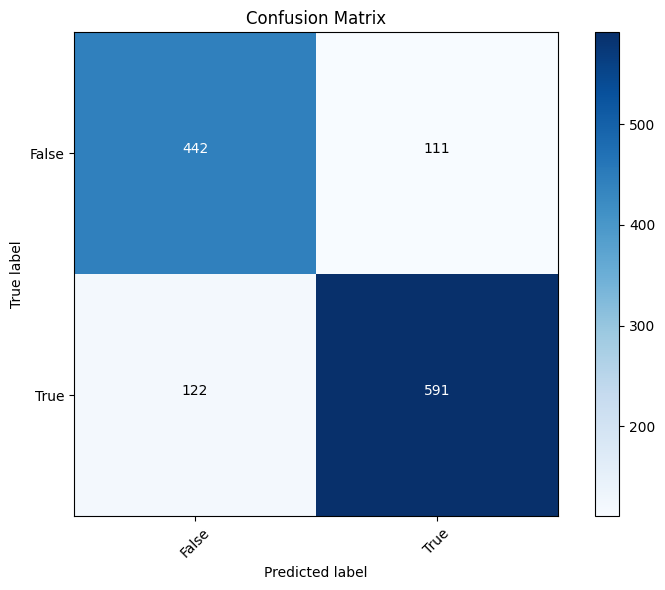

In [ ]:
# Assuming you have the true labels in `test_labels` and predictions in `test_predictions`
class_labels = ["False", "True"]

# Compute the confusion matrix
confusion_mat = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
